In [82]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
from skimage.measure import label

BASE_PATH = "/kaggle/input/data-science-bowl-2018-competition-merged-mask"
DATASET_PATH = os.path.join(BASE_PATH, "data science bowl 2018", "stage1_train 2")

print("Total samples:", len(os.listdir(DATASET_PATH)))

Total samples: 670


In [83]:
def build_merged_mask(mask_dir, shape):
    merged = np.zeros(shape, dtype=np.uint8)
    
    for file in os.listdir(mask_dir):
        m = cv2.imread(os.path.join(mask_dir, file), 0)
        if m is not None:
            merged = np.maximum(merged, m)
            
    return (merged > 0).astype(np.uint8)

In [84]:
def watershed_no_markers(distance, mask):
    labels = watershed(-distance, mask=mask)
    return labels

In [85]:
def watershed_with_markers(distance, mask, min_distance):
    
    coords = peak_local_max(
        distance,
        min_distance=min_distance,
        labels=mask
    )

    markers = np.zeros(distance.shape, dtype=int)
    
    for i, (r, c) in enumerate(coords):
        markers[r, c] = i + 1

    markers = label(markers)

    labels_ws = watershed(-distance, markers, mask=mask)
    
    return labels_ws

In [86]:
def count_error(pred_labels, gt_count):
    return abs(pred_labels.max() - gt_count)

In [87]:
sample_folder = os.listdir(DATASET_PATH)[4]

img_dir = os.path.join(DATASET_PATH, sample_folder, "images")
mask_dir = os.path.join(DATASET_PATH, sample_folder, "masks")

img_name = os.listdir(img_dir)[0]

image = cv2.imread(os.path.join(img_dir, img_name))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

merged_mask = build_merged_mask(mask_dir, gray.shape)
gt_count = len(os.listdir(mask_dir))

distance = distance_transform_edt(merged_mask)

print("Ground truth nuclei:", gt_count)

Ground truth nuclei: 13


min_distance= 2 → nuclei= 18 | error=5
min_distance= 4 → nuclei= 12 | error=1
min_distance= 6 → nuclei= 12 | error=1
min_distance= 8 → nuclei= 12 | error=1
min_distance=10 → nuclei= 11 | error=2
min_distance=12 → nuclei= 11 | error=2
min_distance=16 → nuclei=  9 | error=4
min_distance=18 → nuclei=  9 | error=4


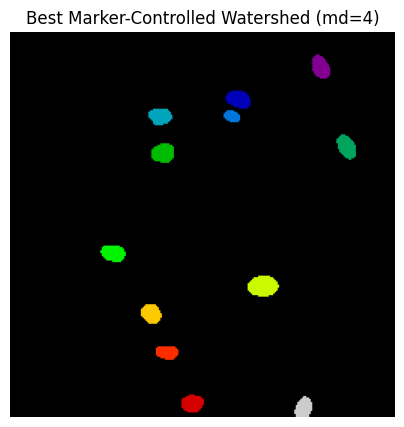


Best min_distance: 4
Best error: 1


In [88]:
marker_distances = [2, 4, 6, 8, 10, 12, 16,18]

best_md = None
best_error = float("inf")
best_labels = None

for md in marker_distances:
    
    labels_ws = watershed_with_markers(distance, merged_mask, md)
    error = count_error(labels_ws, gt_count)

    print(f"min_distance={md:>2} → nuclei={labels_ws.max():>3} | error={error}")

    if error < best_error:
        best_error = error
        best_md = md
        best_labels = labels_ws


plt.figure(figsize=(5,5))
plt.title(f"Best Marker-Controlled Watershed (md={best_md})")
plt.imshow(best_labels, cmap="nipy_spectral")
plt.axis("off")
plt.show()

print("\nBest min_distance:", best_md)
print("Best error:", best_error)

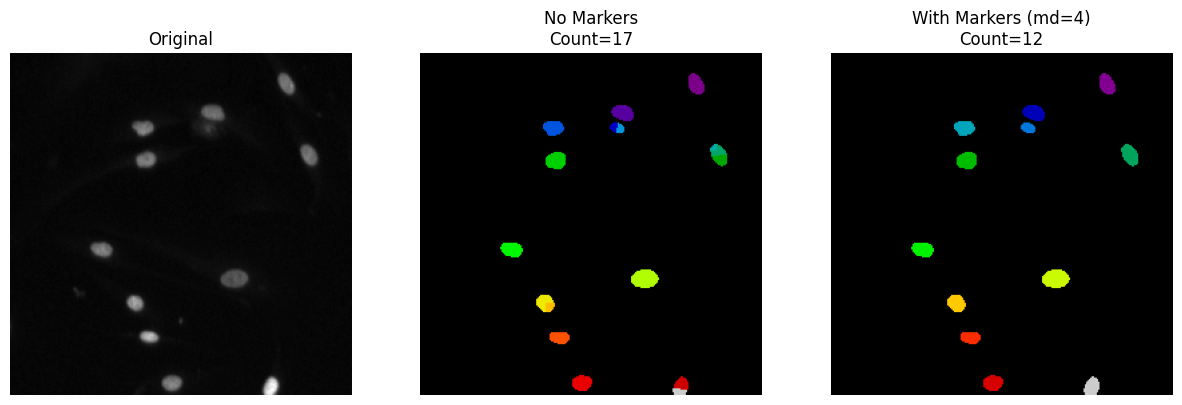

In [89]:
naive_labels = watershed_no_markers(distance, merged_mask)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(naive_labels, cmap='nipy_spectral')
plt.title(f"No Markers\nCount={naive_labels.max()}")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(best_labels, cmap='nipy_spectral')
plt.title(f"With Markers (md={best_md})\nCount={best_labels.max()}")
plt.axis("off")

plt.show()

In [90]:
MAX_IMAGES = 10
marker_distances =  [2, 4, 6, 8, 10, 12, 16,18]

errors = {md: [] for md in marker_distances}

for folder in os.listdir(DATASET_PATH)[:MAX_IMAGES]:
    
    img_dir = os.path.join(DATASET_PATH, folder, "images")
    mask_dir = os.path.join(DATASET_PATH, folder, "masks")

    img_name = os.listdir(img_dir)[0]
    image = cv2.imread(os.path.join(img_dir, img_name))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    merged_mask = build_merged_mask(mask_dir, gray.shape)
    gt_count = len(os.listdir(mask_dir))

    distance = distance_transform_edt(merged_mask)

    for md in marker_distances:
        labels_ws = watershed_with_markers(distance, merged_mask, md)
        error = count_error(labels_ws, gt_count)
        errors[md].append(error)

min_distance=2 → Avg Error=19.20
min_distance=4 → Avg Error=4.00
min_distance=6 → Avg Error=2.30
min_distance=8 → Avg Error=3.80
min_distance=10 → Avg Error=4.50
min_distance=12 → Avg Error=6.00
min_distance=16 → Avg Error=9.40
min_distance=18 → Avg Error=9.60


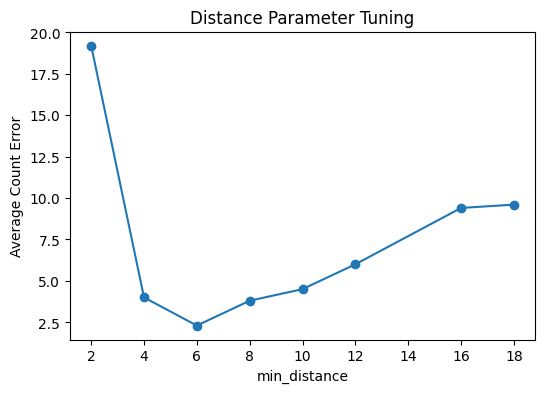

In [91]:
avg_errors = []

for md in marker_distances:
    avg_error = np.mean(errors[md])
    avg_errors.append(avg_error)
    print(f"min_distance={md} → Avg Error={avg_error:.2f}")

plt.figure(figsize=(6,4))
plt.plot(marker_distances, avg_errors, marker='o')
plt.xlabel("min_distance")
plt.ylabel("Average Count Error")
plt.title("Distance Parameter Tuning")
plt.show()